# Comet MLfrom comet_ml import Experiment

In [ ]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="HeNPARP7EmQTxxVRpewzuqm8b",
    project_name="face-normal-liveness",
    workspace="ahmadirfaan",
)

In [ ]:
hyper_params = {
    "input_size": 224,
    "num_classes": 2,
    "batch_size": 32,
    "learning_rate": 2e-4
}

In [ ]:
experiment.log_parameters(hyper_params)

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset and Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsampler import ImbalancedDatasetSampler

In [4]:
bs = 32
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train = datasets.ImageFolder("train", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [5]:
len(train_set), len(val_set)

(18015, 3179)

In [6]:
label2cat = data_train.classes
label2cat

['0_spoof', '1_live']

# Architecture and Config

In [7]:
# import timm
# m = timm.create_model('vit_base_patch16_224')
# m
# del m

In [8]:
import torch
from torch import nn
import timm

class VisionTransformer(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.freeze()
        self.basemodel.head = nn.Sequential(
            nn.Linear(768, output_size),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [9]:
config = set_config({
    "output_size": len(data_train.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

# Training

In [10]:
from collections import Counter

In [11]:
def get_conf_matrix(output, target):
    output, target = output.detach().cpu().numpy(), target.detach().cpu().numpy()
    fp = fn = tp = tn = 0
    for o, t in zip(output, target):
        if(o==1 and t==1):
            tp+=1
        if(o==1 and t==0):
            fp+=1
        if(o==0 and t==1):
            fn+=1
        if(o==0 and t==0):
            tn+=0
    return tn, fp, fn, tp

In [12]:
model = VisionTransformer().to(device)
# model.unfreeze()

In [13]:
def countWeightForClass(n_samples,
                n_classes,
                n_samples_with_class):
    return n_samples / (n_classes * n_samples_with_class)

In [14]:
def countWeight(data_train):
    counter = Counter(data_train.targets)
    labels_count = dict(counter)
    lst = []
    for k in sorted(labels_count):
        lst.append(labels_count[k])
    n_samples = sum(lst)
    n_classes = len(data_train.classes)
    weight = []
    for n_samples_with_class in lst:
        weight.append(countWeightForClass(n_samples, n_classes, n_samples_with_class))
    return weight

In [15]:
weight = countWeight(data_train)
weight

[0.6393749245806685, 2.2937229437229436]

In [16]:
criterion = nn.CrossEntropyLoss(torch.tensor(weight).to(device))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step_size=3, gamma=0.1)
callback = Callback(model, config, early_stop_patience=4, outdir="model")

In [17]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [18]:
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device, experiment, epoch, step):
    if mode == "train":
        model.train()
        cost = correct = total = 0
        tp = fp = tn = fn = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            total += len(feature)
            output = model(feature)
            loss = criterion(output, target)
            if mode == "train":
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            cost += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
    #         print(target)
    #         cf_matrix = confusion_matrix(target.cpu().numpy(), output.argmax(1).cpu().numpy())
    #         tn_temp, fp_temp, fn_temp, tp_temp = cf_matrix.ravel()
#             experiment.log_metric("train_step_accuracy", correct / total, step=step)
#             experiment.log_metric("train_step_loss", cost / total, step=step)
            step+=1
        cost = cost / len(dataset)
        acc = correct / len(dataset)
#         experiment.log_metric("train_accuracy", acc, epoch=epoch)
#         experiment.log_metric("train_loss", cost, epoch=epoch)
        return cost, acc, epoch, step
    elif mode == "test":
        model.eval()
        targets, preds_out, probs = predict(model, dataloader, device)
        acc = accuracy_score(targets, preds_out)
        cost = criterion(torch.tensor(probs).to(device), torch.tensor(targets).to(device))
#         cost = cost / len(dataset)
#         acc = correct / len(dataset)
#         experiment.log_metric("test_accuracy", acc, epoch=epoch)
#         experiment.log_metric("test_loss", cost, epoch=epoch)
        cf_matrix = confusion_matrix(targets, preds_out)
        tn, fp, fn, tp = cf_matrix.ravel()
        apcer = fp / (tn + fp)
        bpcer = fn / (fn + tp)
        acer = (apcer + bpcer) / 2
#         experiment.log_metric("APCER", apcer, epoch=epoch)
#         experiment.log_metric("BPCER", bpcer, epoch=epoch)
#         experiment.log_metric("ACER", acer, epoch=epoch)
        step+=1
        return cost, acc, epoch, step

In [19]:
import os

In [20]:
epoch=0
step=0
while True:
    train_cost, train_score, epoch, step = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device, None, epoch, step)
#     if not os.path.exists(f"model vit fix/epoch-{epoch}/"):
#         os.makedirs(f"model vit fix/epoch-{epoch}/")
#     torch.save(model.state_dict(), f"model vit fix/epoch-{epoch}/model.pth")
    with torch.no_grad():
        test_cost, test_score, epoch, step = loop_fn("test", val_set, valloader, model, criterion, optimizer, device, None, epoch, step)
    epoch+=1

  # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
    callback.save_checkpoint()

  # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

  # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3496 | Test_cost  = 0.4174 | Train_score = 0.8428 | Test_score = 0.9226 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1881 | Test_cost  = 0.3909 | Train_score = 0.9334 | Test_score = 0.9396 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1475 | Test_cost  = 0.3783 | Train_score = 0.9487 | Test_score = 0.9512 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1253 | Test_cost  = 0.3706 | Train_score = 0.9570 | Test_score = 0.9547 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1108 | Test_cost  = 0.3653 | Train_score = 0.9626 | Test_score = 0.9569 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1005 | Test_cost  = 0.3614 | Train_score = 0.9659 | Test_score = 0.9578 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0927 | Test_cost  = 0.3585 | Train_score = 0.9684 | Test_score = 0.9591 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0865 | Test_cost  = 0.3562 | Train_score = 0.9706 | Test_score = 0.9610 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0815 | Test_cost  = 0.3543 | Train_score = 0.9720 | Test_score = 0.9619 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0774 | Test_cost  = 0.3528 | Train_score = 0.9738 | Test_score = 0.9619 |
==> EarlyStop patience =  1 | Best test_score: 0.9619


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0739 | Test_cost  = 0.3516 | Train_score = 0.9754 | Test_score = 0.9632 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0708 | Test_cost  = 0.3505 | Train_score = 0.9760 | Test_score = 0.9638 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0681 | Test_cost  = 0.3495 | Train_score = 0.9770 | Test_score = 0.9635 |
==> EarlyStop patience =  1 | Best test_score: 0.9638


Train:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0658 | Test_cost  = 0.3487 | Train_score = 0.9781 | Test_score = 0.9657 |


Train:   0%|          | 0/563 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
experiment.end()

# Evaluation

## Validation Score

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [31]:
bs = 16
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_benchmark = datasets.ImageFolder("val", transform=transform)

# data_train = datasets.ImageFolder("output2/train", transform=transform)
# data_val = datasets.ImageFolder("output2/val", transform=transform)
# data_test = datasets.ImageFolder("output2/test", transform=transform)

# Split into Train Val

benchmarkloader = DataLoader(data_benchmark, batch_size=bs)

In [32]:
torch.save(model.state_dict(), "model vit v2.pth")

In [33]:
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

In [34]:
print(classification_report(target, preds, target_names=label2cat))

              precision    recall  f1-score   support

     0_spoof       0.99      0.98      0.99      4144
      1_live       0.93      0.97      0.95      1156

    accuracy                           0.98      5300
   macro avg       0.96      0.97      0.97      5300
weighted avg       0.98      0.98      0.98      5300



In [35]:
cf_matrix = confusion_matrix(target, preds)
cf_matrix

array([[4061,   83],
       [  37, 1119]])

In [36]:
tn, fp, fn, tp = cf_matrix.ravel()

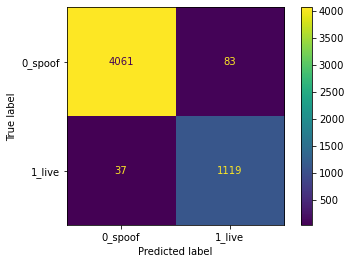

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Calculate Metric

In [38]:
apcer = fp / (tn + fp)
npcer = fn / (fn + tp)

acer = (apcer + npcer) / 2
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

In [39]:
print(f'APCER / FPR: {apcer*100:.{4}f}')
print(f'NPCER / FNR: {npcer*100:.{4}f}')
print(f'ACER: {acer*100:.{4}f}')
print(f'TPR: {tpr*100:.{4}f}')
print(f'TNR: {tnr*100:.{4}f}')

APCER / FPR: 2.0029
NPCER / FNR: 3.2007
ACER: 2.6018
TPR: 96.7993
TNR: 97.9971


In [40]:
model.load_state_dict(torch.load('model vit v2.pth', map_location=device))

<All keys matched successfully>